# 1. Cài đặt các thư viện cần thiết

In [1]:
# load pre-trained BERT và tune
!pip install transformers
!pip install fastBPE
!pip install fairseq

  Preparing metadata (setup.py) ... done
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp37-cp37m-linux_x86_64.whl size=746863 sha256=012b486376a8374cee1e12dfcba1089e2dcde8809effeb19352491786264762e
  Stored in directory: /root/.cache/pip/wheels/bd/d4/0e/0d317a65f77d3f8049fedd8a2ee0519164cf3e6bd77ef886f1
Successfully built fastBPE
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 15.4 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.3/278.3 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=7df73a7886e15b82bf822add51f8d3a6426575671677eb924ba83b65e860eafc
  Stored in directory: /r

In [2]:
# Thư viện vncorenlp và wordsegmenter dùng để Word Segmentation cho tiếng Việt

# Install the vncorenlp python wrapper
!pip install vncorenlp

# Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/ 
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 23.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=b544e8df8918ee77d46a6185816f8cfdcdc9ffe95ec419af6db0c7c159dbe0ec
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
--2023-11-29 12:58:00--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   156MB/s    in 0.2s    

2023-11-29 12:58:01 (156 MB/s) - 

In [3]:
# Tải về bộ dữ liệu huấn luyện từ trang chủ cuộc thi của AIVIVN và 
# pre-trained của PhoBERT xong tiến hành giải nén

!wget https://public.vinai.io/PhoBERT_base_transformers.tar.gz
!tar -xzvf PhoBERT_base_transformers.tar.gz

--2023-11-29 12:58:07--  https://public.vinai.io/PhoBERT_base_transformers.tar.gz
Resolving public.vinai.io (public.vinai.io)... 54.230.31.104, 54.230.31.76, 54.230.31.108, ...
Connecting to public.vinai.io (public.vinai.io)|54.230.31.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322405979 (307M) [application/x-tar]
Saving to: ‘PhoBERT_base_transformers.tar.gz’

PhoBERT_base_transf 100%[===================>] 307.47M  93.5MB/s    in 3.3s    

2023-11-29 12:58:11 (92.8 MB/s) - ‘PhoBERT_base_transformers.tar.gz’ saved [322405979/322405979]

PhoBERT_base_transformers/
PhoBERT_base_transformers/config.json
PhoBERT_base_transformers/bpe.codes
PhoBERT_base_transformers/model.bin
PhoBERT_base_transformers/dict.txt


# 2. Import các thư viện cần thiết

In [4]:
import os
import torch
import pickle
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from vncorenlp import VnCoreNLP

import argparse
from fairseq.data import Dictionary
from fairseq.data.encoders.fastbpe import fastBPE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score

from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import RobertaForSequenceClassification, RobertaConfig, AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import warnings
warnings.filterwarnings("ignore")

# 3. Load data và tiền xử lý dữ liệu

In [5]:
# tạo bộ word segmentation cho tiếng Việt
rdrsegmenter = VnCoreNLP("./vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

In [6]:
# load model và bpe lên theo hướng dẫn của PhoBERT
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="./PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()
bpe = fastBPE(args)

# Load the dictionary
vocab = Dictionary()
vocab.add_from_file("./PhoBERT_base_transformers/dict.txt")

Loading codes from ./PhoBERT_base_transformers/bpe.codes ...
Read 64000 codes from the codes file.


In [7]:
# lấy đường dẫn của file Train và file Test
path_train = '../input/vietnamese-text-classification/data/Train/'
path_test = '../input/vietnamese-text-classification/data/Test/'

In [8]:
# hàm để đọc file txt
# input: đường dẫn file
# output: nội dung của file
def read_txt(path):
    try:
        with open(path, 'r', encoding='utf-16') as f:       # Train
            data = f.read()
    except:
        with open(path, 'r', encoding='utf-8') as f:        # Test
            data = f.read()
    return data

In [9]:
# hàm để lấy ra nội dung của file txt và label tương ứng
# input: đường dẫn đến thư mục (Train hoặc Test)
# output: nội dung và label tương ứng
def make_data(path_data):
    texts = []
    labels = []

    for name_folder in os.listdir(path_data):      # lấy các thư mục con
        path_folder = os.path.join(path_data, name_folder)
        print(path_folder)
        for file_txt in os.listdir(path_folder):   # lấy các file .txt    
            path_file = os.path.join(path_folder, file_txt)

            content = read_txt(path_file)          # đọc file .txt
            content = rdrsegmenter.tokenize(content)   # word segmentaition cho tiếng Việt
            content = ' '.join([' '.join(x) for x in content])
        
            texts.append(content)
            labels.append(name_folder)
            
    return texts, labels

#### Lấy ra nội dung của file txt và label tương ứng của file Train và Test

In [10]:
train_text, train_labels = make_data(path_train)
test_text, test_labels = make_data(path_test)

print(len(train_text), len(train_labels))
print(len(test_text), len(test_labels))

../input/vietnamese-text-classification/data/Train/The gioi
../input/vietnamese-text-classification/data/Train/Phap luat
../input/vietnamese-text-classification/data/Train/Khoa hoc
../input/vietnamese-text-classification/data/Train/The thao
../input/vietnamese-text-classification/data/Train/Kinh doanh
../input/vietnamese-text-classification/data/Train/Suc khoe
../input/vietnamese-text-classification/data/Train/Doi song
../input/vietnamese-text-classification/data/Train/Van hoa
../input/vietnamese-text-classification/data/Test/The gioi
../input/vietnamese-text-classification/data/Test/Phap luat
../input/vietnamese-text-classification/data/Test/Khoa hoc
../input/vietnamese-text-classification/data/Test/The thao
../input/vietnamese-text-classification/data/Test/Kinh doanh
../input/vietnamese-text-classification/data/Test/Suc khoe
../input/vietnamese-text-classification/data/Test/Doi song
../input/vietnamese-text-classification/data/Test/Van hoa
26059 26059
2400 2400


In [11]:
# in kiểm tra kết quả
train_text[0], train_labels[0]

('Nuôi một đứa con ở TQ , cần có 60.000 USD Chi_phí nuôi con chiếm 40-50% thu_nhập các gia_đình TQ Nuôi một đứa con ở Trung_Quốc ( TQ ) tốn_kém bao_nhiêu ? Phần_lớn các bậc cha_mẹ TQ không suy_nghĩ đến vấn_đề này cho đến khi họ bị “ sốc ” với kết_quả một cuộc khảo_sát mới_đây của Viện Khoa_học_Xã_hội Thượng_Hải . Theo cuộc khảo_sát này , bình_quân mỗi gia_đình TQ phải_chi 59.036 USD để nuôi một đứa con . Chi_phí cho việc học ở bậc tiểu_học của trẻ chiếm 46% tổng chi_tiêu trong gia_đình , chi_phí cho việc học trung_học chiếm 51% và chi_phí cho việc học đại_học là 52% . Đó là chưa kể nếu gửi con đi du_học thì chi_phí còn cao hơn nhiều . Không ngạc_nhiên gì việc quá nhiều tiền đổ vào việc học_hành của trẻ ở TQ . Chính việc học_hành của trẻ đã đẩy chi_phí nuôi con lên đến mức mà những_ai lớn lên trong những năm 1970 và 1980 ở nước này khó có_thể tưởng_tượng . Trường_học ở TQ ngày_nay không còn giống như loại trường_học của non nửa thế_kỷ trước_đây , khi học_sinh TQ được phép vào học miễn_p

#### Khởi tạo bộ encoder để mã hóa các labels

In [12]:
lb_encoder = LabelEncoder()
lb_encoder.fit(train_labels)

en_train_labels = lb_encoder.transform(train_labels)
en_test_labels = lb_encoder.transform(test_labels)

print(lb_encoder.classes_)  # in kiểm tra các labels

['Doi song' 'Khoa hoc' 'Kinh doanh' 'Phap luat' 'Suc khoe' 'The gioi'
 'The thao' 'Van hoa']


#### Tách tập train thành 2 tập: train và validation theo tỉ lệ 90:10.

In [13]:
train_sents, val_sents, train_labels, val_labels = train_test_split(train_text, en_train_labels, test_size=0.1)
len(train_sents), len(val_sents)

(23453, 2606)

#### Sử dụng **bpe** đã load ở trên để đưa text đầu vào dưới dạng subword và ánh xạ các subword này về dạng index trong từ điển:

In [14]:
MAX_LEN = 256

def convert_sents_ids(sents):
    ids = []
    for sent in sents:
        subwords = '<s> ' + bpe.encode(sent) + ' </s>'
        encoded_sent = vocab.encode_line(subwords, append_eos=True, add_if_not_exist=False).long().tolist()
        ids.append(encoded_sent)
    ids = pad_sequences(ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
    return torch.tensor(ids)
    
train_ids = convert_sents_ids(train_sents)
val_ids = convert_sents_ids(val_sents)
test_ids = convert_sents_ids(test_text)

#### **train_ids** bây giờ đã trở thành một list dữ liệu mẫu trong đó mỗi mẫu là một list id của các subword có trong từ điển. Các câu ngắn hơn 256 subword được padding 0 ở cuối, những câu dài hơn được cắt đi cho đủ 256.

#### Tạo một mask gồm các giá trị 0, 1 để làm đầu vào cho thư viện transformers, mask này cho biết các giá trị nào của chuỗi đã được padding.

In [15]:
def make_mask(batch_ids):
    batch_mask = []
    for ids in batch_ids:
        mask = [int(token_id > 0) for token_id in ids]
        batch_mask.append(mask)
    return torch.tensor(batch_mask)

train_masks = make_mask(train_ids)
val_masks = make_mask(val_ids)
test_masks = make_mask(test_ids)

#### Sử dụng **DataLoader** của torch để tạo dataloader

In [16]:
def make_data_loader(ids, masks, labels, BATCH_SIZE=4): 
    data = TensorDataset(ids, masks, labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=BATCH_SIZE) #32
    return dataloader

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)
test_labels = torch.tensor(en_test_labels)

train_dataloader = make_data_loader(train_ids, train_masks, train_labels)
val_dataloader = make_data_loader(val_ids, val_masks, val_labels)
test_dataloader = make_data_loader(test_ids, test_masks, test_labels)

# 4. Model PhoBERT - Transformer

## 4.1. Xây dựng model

#### Load model **PhoBERT**

In [17]:
NUM_LABELS = len(lb_encoder.classes_)
config = RobertaConfig.from_pretrained(
    "./PhoBERT_base_transformers/config.json", from_tf=False, num_labels = NUM_LABELS, output_hidden_states=False,
)
PHO_BERT = RobertaForSequenceClassification.from_pretrained(
    "./PhoBERT_base_transformers/model.bin",
    config=config
)

PHO_BERT.cuda()
print('Done')

You are using a model of type bert to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at ./PhoBERT_base_transformers/model.bin were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenc

Done


#### Xây dựng hàm đánh giá cho model training

In [18]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    F1_score = f1_score(pred_flat, labels_flat, average='macro')
    
    return accuracy_score(pred_flat, labels_flat), F1_score

## 4.2. Training

In [19]:
device = 'cuda'
EPOCHS = 5

param_optimizer = list(PHO_BERT.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=1e-5, correct_bias=False)

TRAIN_ACCURACY, TRAIN_F1, TRAIN_LOSS, VAL_ACCURACY , VAL_F1 = [], [], [], [], []

for epoch_i in range(0, EPOCHS):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, EPOCHS))
    print('Training...')

    total_loss = 0
    PHO_BERT.train()
    train_accuracy = 0
    nb_train_steps = 0
    train_f1 = 0
    
    for step, batch in tqdm(enumerate(train_dataloader)):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        PHO_BERT.zero_grad()
        outputs = PHO_BERT(b_input_ids, 
            token_type_ids=None, 
            attention_mask=b_input_mask, 
            labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_train_accuracy, tmp_train_f1 = flat_accuracy(logits, label_ids)
        train_accuracy += tmp_train_accuracy
        train_f1 += tmp_train_f1
        nb_train_steps += 1
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(PHO_BERT.parameters(), 1.0)
        optimizer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    
    TRAIN_LOSS.append(avg_train_loss)
    TRAIN_ACCURACY.append(train_accuracy/nb_train_steps)
    TRAIN_F1.append(train_f1/nb_train_steps)
    print(" Accuracy: {0:.4f}".format(train_accuracy/nb_train_steps))
    print(" F1 score: {0:.4f}".format(train_f1/nb_train_steps))
    print(" Average training loss: {0:.4f}".format(avg_train_loss))

    print("Running Validation...")
    PHO_BERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    for batch in tqdm(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = PHO_BERT(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    VAL_ACCURACY.append(eval_accuracy/nb_eval_steps)
    VAL_F1.append(eval_f1/nb_eval_steps)
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
print("Training complete!")

======== Epoch 1 / 5 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9397
 F1 score: 0.9088
 Average training loss: 0.2830
Running Validation...


  0%|          | 0/652 [00:00<?, ?it/s]

 Accuracy: 0.9471
 F1 score: 0.9183
======== Epoch 2 / 5 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9716
 F1 score: 0.9558
 Average training loss: 0.1486
Running Validation...


  0%|          | 0/652 [00:00<?, ?it/s]

 Accuracy: 0.9505
 F1 score: 0.9254
======== Epoch 3 / 5 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9850
 F1 score: 0.9764
 Average training loss: 0.0902
Running Validation...


  0%|          | 0/652 [00:00<?, ?it/s]

 Accuracy: 0.9528
 F1 score: 0.9274
======== Epoch 4 / 5 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9904
 F1 score: 0.9852
 Average training loss: 0.0582
Running Validation...


  0%|          | 0/652 [00:00<?, ?it/s]

 Accuracy: 0.9509
 F1 score: 0.9239
======== Epoch 5 / 5 ========
Training...


0it [00:00, ?it/s]

 Accuracy: 0.9925
 F1 score: 0.9882
 Average training loss: 0.0453
Running Validation...


  0%|          | 0/652 [00:00<?, ?it/s]

 Accuracy: 0.9548
 F1 score: 0.9301
Training complete!


#### Lưu model

In [20]:
torch.save(PHO_BERT.state_dict(), f'phobert_text_classification.pth')

## 4.3. Đánh giá trên tập Test

In [21]:
# Xây dựng hàm đánh giá cho tập test
def test(data_loader):
    PHO_BERT.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    eval_f1 = 0
    predicts = []
    real_values = []
    for batch in tqdm(data_loader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = PHO_BERT(b_input_ids, 
                              token_type_ids=None, 
                              attention_mask=b_input_mask)
            logits = outputs[0]
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            predicts.append(np.argmax(logits, axis=1))
            real_values.append(label_ids)
            tmp_eval_accuracy, tmp_eval_f1 = flat_accuracy(logits, label_ids)

            eval_accuracy += tmp_eval_accuracy
            eval_f1 += tmp_eval_f1
            nb_eval_steps += 1
    print(" Accuracy: {0:.4f}".format(eval_accuracy/nb_eval_steps))
    print(" F1 score: {0:.4f}".format(eval_f1/nb_eval_steps))
    
    predicts = np.array(predicts).flatten()
    real_values = np.array(real_values).flatten()
    
    print('\n', classification_report(real_values, predicts))

In [22]:
test(test_dataloader)

  0%|          | 0/600 [00:00<?, ?it/s]

 Accuracy: 0.7662
 F1 score: 0.6720

               precision    recall  f1-score   support

           0       0.45      0.45      0.45       300
           1       0.75      0.91      0.82       300
           2       0.85      0.88      0.87       300
           3       0.90      0.90      0.90       300
           4       0.74      0.96      0.84       300
           5       0.81      0.91      0.86       300
           6       0.94      0.99      0.97       300
           7       0.46      0.13      0.20       300

    accuracy                           0.77      2400
   macro avg       0.74      0.77      0.74      2400
weighted avg       0.74      0.77      0.74      2400



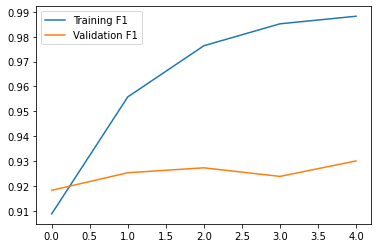

In [23]:
plt.plot(TRAIN_F1, label='Training F1')
plt.plot(VAL_F1, label='Validation F1')
plt.legend()
plt.show()

# 5. Model LSTM

## 5.1. Xây dựng model

In [24]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(np.array(train_labels))
y_val = to_categorical(np.array(val_labels))

In [25]:
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout
from keras import layers, Sequential

vocab_size = len(vocab)
embedding_dim = 128
hidden_size = 256

model_LSTM = Sequential()

model_LSTM.add(layers.Embedding(vocab_size, embedding_dim,input_length=np.array(train_ids).shape[1]))
model_LSTM.add(layers.LSTM(hidden_size, return_sequences=True)) 
model_LSTM.add(Dropout(0.2))
model_LSTM.add(layers.LSTM(hidden_size))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(layers.Dense(128,activation='relu'))
model_LSTM.add(layers.Dense(y_train.shape[1], activation='softmax'))

model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_LSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 128)          8192000   
_________________________________________________________________
lstm (LSTM)                  (None, 256, 256)          394240    
_________________________________________________________________
dropout (Dropout)            (None, 256, 256)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1

## 5.2. Training model

In [26]:
model_LSTM_history = model_LSTM.fit(np.array(train_ids),y_train, epochs=EPOCHS, batch_size = 4, verbose=1, validation_data=(np.array(val_ids),y_val))

Epoch 1/5
5864/5864 [==============================] - 162s 27ms/step - loss: 1.6676 - accuracy: 0.3352 - val_loss: 1.0902 - val_accuracy: 0.5380
Epoch 2/5
5864/5864 [==============================] - 157s 27ms/step - loss: 0.8163 - accuracy: 0.6571 - val_loss: 0.6903 - val_accuracy: 0.7659
Epoch 3/5
5864/5864 [==============================] - 157s 27ms/step - loss: 0.4462 - accuracy: 0.8491 - val_loss: 0.3624 - val_accuracy: 0.8895
Epoch 4/5
5864/5864 [==============================] - 156s 27ms/step - loss: 0.2488 - accuracy: 0.9274 - val_loss: 0.3174 - val_accuracy: 0.9114
Epoch 5/5
5864/5864 [==============================] - 157s 27ms/step - loss: 0.1541 - accuracy: 0.9561 - val_loss: 0.3405 - val_accuracy: 0.9048


In [27]:
model_LSTM.save_weights('LSTM_text_classification.h5')

## 5.3. Đánh giá trên tập Test

In [28]:
# xây dựng hàm đánh giá
def test_LSTM(X_test, y_test):
    y_pred = model_LSTM.predict(X_test)
    pred = np.argmax(y_pred,axis=1) 

    print(classification_report(y_test, pred))

# đánh giá trên tập test
test_LSTM(np.array(test_ids), np.array(test_labels))

              precision    recall  f1-score   support

           0       0.42      0.49      0.45       300
           1       0.61      0.74      0.67       300
           2       0.77      0.82      0.80       300
           3       0.93      0.73      0.81       300
           4       0.62      0.94      0.75       300
           5       0.75      0.79      0.77       300
           6       0.91      0.96      0.94       300
           7       0.51      0.07      0.13       300

    accuracy                           0.69      2400
   macro avg       0.69      0.69      0.66      2400
weighted avg       0.69      0.69      0.66      2400



In [34]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import time

# Assuming train_ids and val_ids are sequences of word indices
train_texts = [" ".join(map(str, seq)) for seq in train_ids]
val_texts = [" ".join(map(str, seq)) for seq in val_ids]

start_time = time.time()

ln_model = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1), max_df=0.8, max_features=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000)))
])

ln_model = ln_model.fit(train_texts, y_train)

train_time = time.time() - start_time
print('Done training Linear Classifier in', train_time, 'seconds.')


Done training Linear Classifier in 33.06691098213196 seconds.


In [75]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, test_data, true_labels):
    # Chuyển đổi dữ liệu kiểm thử thành văn bản (nếu cần thiết)
    test_texts = [" ".join(map(str, seq)) for seq in test_data]

    # Dự đoán nhãn trên tập kiểm thử
    predicted_labels = model.predict(test_texts)

    # Đánh giá độ chính xác
    accuracy = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # In báo cáo phân loại
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

# Sử dụng hàm evaluate_model với mô hình đã huấn luyện và tập kiểm thử
ln_accuracy = evaluate_model(ln_model, val_ids, y_val)

Accuracy: 0.8200306983883346

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       292
           1       0.98      0.52      0.68       181
           2       0.95      0.79      0.86       256
           3       0.98      0.90      0.94       396
           4       0.96      0.86      0.91       350
           5       0.99      0.78      0.87       305
           6       1.00      0.95      0.97       532
           7       0.98      0.84      0.91       294

   micro avg       0.97      0.83      0.89      2606
   macro avg       0.97      0.80      0.87      2606
weighted avg       0.97      0.83      0.89      2606
 samples avg       0.82      0.83      0.82      2606



In [37]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import time

# Giả sử train_ids và val_ids là các dãy số (sequences) từ điển
train_texts = [" ".join(map(str, seq)) for seq in train_ids]
val_texts = [" ".join(map(str, seq)) for seq in val_ids]

start_time = time.time()

nb_model = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 1), max_df=0.8, max_features=None)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(MultinomialNB()))
])

nb_model = nb_model.fit(train_texts, y_train)

train_time = time.time() - start_time
print('Hoàn thành việc huấn luyện Mô hình Naive Bayes trong', train_time, 'giây.')



Hoàn thành việc huấn luyện Mô hình Naive Bayes trong 11.567488670349121 giây.


In [43]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model_multi_output(model, test_data, true_labels):
    # Chuyển đổi dữ liệu kiểm thử thành văn bản (nếu cần thiết)
    test_texts = [" ".join(map(str, seq)) for seq in test_data]

    # Dự đoán nhãn trên tập kiểm thử
    predicted_labels = model.predict(test_texts)

    # Đánh giá độ chính xác
    nb_accuracy =  = accuracy_score(true_labels, predicted_labels)
    print("Accuracy:", accuracy)

    # In báo cáo phân loại
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels))

# Sử dụng hàm evaluate_model_multi_output với mô hình đã huấn luyện và tập kiểm thử
evaluate_model_multi_output(nb_model, val_ids, y_val)


Accuracy: 0.6254796623177283

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.49      0.65       292
           1       1.00      0.05      0.09       181
           2       1.00      0.46      0.63       256
           3       0.99      0.81      0.89       396
           4       0.99      0.70      0.82       350
           5       1.00      0.56      0.72       305
           6       1.00      0.90      0.95       532
           7       0.99      0.49      0.65       294

   micro avg       0.99      0.63      0.77      2606
   macro avg       0.99      0.56      0.68      2606
weighted avg       0.99      0.63      0.74      2606
 samples avg       0.63      0.63      0.63      2606



# 6. Vẽ biểu đồ so sánh 2 mô hình Transformer và LSTM

## 6.1. Accuracy

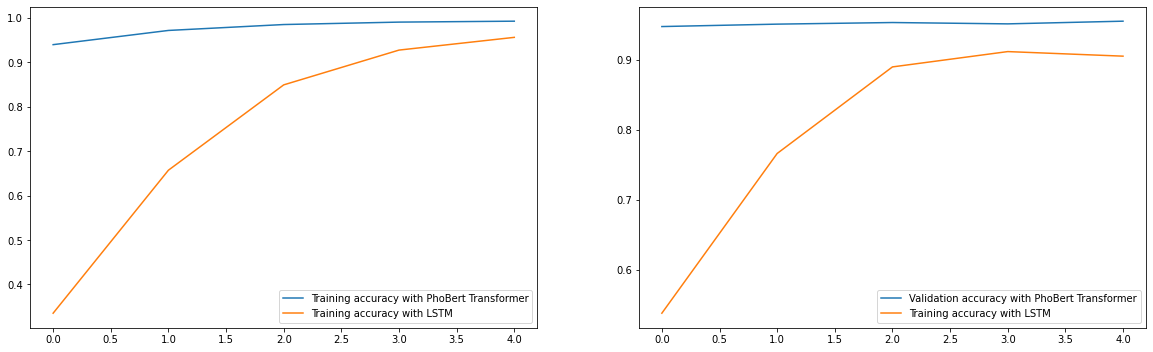

In [45]:
plt.figure(figsize=(20,13))
plt.subplot(2,2,1)
plt.plot(TRAIN_ACCURACY, label='Training accuracy with PhoBert Transformer')
plt.plot(model_LSTM_history.history['accuracy'], label='Training accuracy with LSTM')


plt.legend()

plt.subplot(2,2,2)
plt.plot(VAL_ACCURACY, label='Validation accuracy with PhoBert Transformer')
plt.plot(model_LSTM_history.history['val_accuracy'], label='Training accuracy with LSTM')
plt.legend()

plt.show()

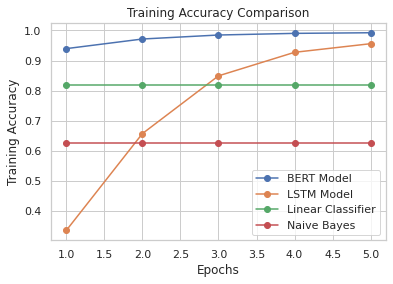

In [76]:
import matplotlib.pyplot as plt

epochs = range(1, EPOCHS + 1)

# Plotting BERT model accuracy
plt.plot(epochs, TRAIN_ACCURACY, label='BERT Model', marker='o')

# Assuming model_LSTM_history.history['accuracy'] contains the LSTM model accuracy
plt.plot(epochs, model_LSTM_history.history['accuracy'], label='LSTM Model', marker='o')

# Plotting Linear Classifier accuracy
ln_accuracy = ln_model.score(val_texts, y_val)
plt.plot(epochs, [ln_accuracy] * EPOCHS, label='Linear Classifier', marker='o')

# Plotting Naive Bayes accuracy
nb_accuracy = nb_model.score(val_texts, y_val)
plt.plot(epochs, [nb_accuracy] * EPOCHS, label='Naive Bayes', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.show()


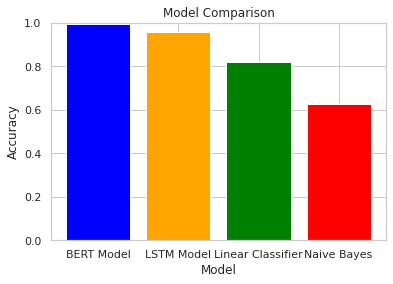

In [77]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, EPOCHS + 1)

# Accuracy values for each model
bert_accuracy = TRAIN_ACCURACY[-1]  # Assuming you want the last epoch accuracy for BERT
lstm_accuracy = model_LSTM_history.history['accuracy'][-1]  # Assuming you want the last epoch accuracy for LSTM
ln_accuracy = ln_model.score(val_texts, y_val)
nb_accuracy = nb_model.score(val_texts, y_val)

# Creating bar plots
plt.bar(['BERT Model', 'LSTM Model', 'Linear Classifier', 'Naive Bayes'],
        [bert_accuracy, lstm_accuracy, ln_accuracy, nb_accuracy],
        color=['blue', 'orange', 'green', 'red'])

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.ylim(0, 1)  # Assuming accuracy is between 0 and 1
plt.show()


## 6.2. Loss

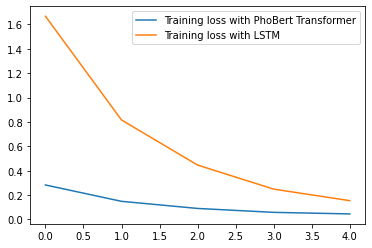

In [30]:
plt.plot(TRAIN_LOSS, label='Training loss with PhoBert Transformer')
plt.plot(model_LSTM_history.history['loss'], label='Training loss with LSTM')
plt.legend()
plt.show()

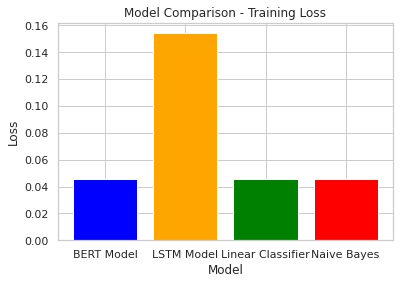

In [78]:
import matplotlib.pyplot as plt
import numpy as np

epochs = range(1, EPOCHS + 1)

# Loss values for each model
bert_loss = TRAIN_LOSS[-1]  # Assuming you want the last epoch loss for BERT
lstm_loss = model_LSTM_history.history['loss'][-1]  # Assuming you want the last epoch loss for LSTM
ln_loss = TRAIN_LOSS[-1]  # Use the training loss for Linear Classifier
nb_loss = TRAIN_LOSS[-1]  # Use the training loss for Naive Bayes

# Creating bar plots
plt.bar(['BERT Model', 'LSTM Model', 'Linear Classifier', 'Naive Bayes'],
        [bert_loss, lstm_loss, ln_loss, nb_loss],
        color=['blue', 'orange', 'green', 'red'])

plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Comparison - Training Loss')
plt.show()
